<a href="https://colab.research.google.com/github/emmenets/neuralnetwork/blob/master/190816Einfuehrung_in_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2019-08-16 13:10:15--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  20.3MB/s    in 9.0s    

2019-08-16 13:10:24 (18.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [4]:
!tar -xvf /content/cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
class CifarLoader(object):
  def __init__(self, source_files):
    self._source = source_files
    self._i = 0
    self.images = None
    self.labels = None

  def load(self):
    data = [unpickle(f) for f in self._source]
    images = np.vstack([d[b"data"] for d in data])
    n = len(images)
    self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1).astype(float) / 255
    self.labels = one_hot(np.hstack([d[b"labels"] for d in data]), 10)
    return self

  def next_batch(self, batch_size):
    x, y = self.images[self._i:self._i+batch_size], self.labels[self._i:self._i+batch_size]
    self._i = (self._i + batch_size) % len(self.images)
    return x, y


In [0]:
DATA_PATH = '/content/cifar-10-batches-py'
def unpickle(file):
  with open(os.path.join(DATA_PATH, file), 'rb') as fo:
    dict = pickle.load(fo, encoding="bytes")
  return dict

def one_hot(vec, vals=10):
  n = len(vec)
  out = np.zeros((n, vals))
  out[range(n), vec] = 1
  return out

In [0]:
class CifarDataManager(object):
  def __init__(self):
    self.train = CifarLoader(["data_batch_{}".format(i)
    for i in range(1, 6)])\
    .load()
    self.test = CifarLoader(["test_batch"]).load()


Anzahl der Bilder zum Anlernen: 50000


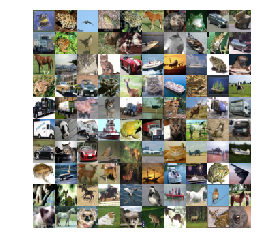

In [25]:
import pickle
def display_cifar(images, size):
  n = len(images)
  plt.figure()
  plt.gca().set_axis_off()
  im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)]) for i in range(size)])
  plt.imshow(im)
  plt.show()



d = CifarDataManager()
print("Anzahl der Bilder zum Anlernen: {}".format(len(d.train.images)))
images = d.train.images
display_cifar(images, 10)

In [0]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def conv_layer(input, shape):
  W = weight_variable(shape)
  b = bias_variable([shape[3]])
  return tf.nn.relu(conv2d(input, W) +b)

def full_layer(input, size):
  in_size = int(input.get_shape()[1])
  W = weight_variable([in_size, size])
  b = bias_variable([size])
  return tf.matmul(input, W) + b

In [0]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x_image, shape=[5, 5, 1, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf. reshape(conv2_pool, [-1, 7*7*64])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)

full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

W0816 11:25:01.591935 140411875473280 deprecation.py:506] From <ipython-input-6-4c5dd5b73f32>:16: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  for i in range(NUM_STEPS):  
    batch = mnist.train.next_batch(50)  
    
    if i % 100 == 0:
      train_accuracy = sess.run(accuracy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
      print("Schritt {}, Genauigkeit Anlernen {}".format(i, train_accuracy))
      
    sess.run(train_step, feed_dict={x: batch[0], y_:batch[1], keep_prob: 0.5})
    
  X = mnist.test.images.reshape(10, 1000, 784)
  Y = mnist.test.labels.reshape(10, 1000, 10)
  test_accuracy = np.mean([sess.run(accuracy, feed_dict={x:X[i], y_:Y[i], keep_prob:1.0})for i in range(10)])
  
  print("Genauigkeit Test: {}".format(test_accuracy))

W0816 11:25:01.635628 140411875473280 deprecation.py:323] From <ipython-input-7-a7a2399f2694>:1: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0816 11:25:01.637301 140411875473280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0816 11:25:01.638909 140411875473280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz


W0816 11:25:02.486081 140411875473280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0816 11:25:02.488548 140411875473280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz


W0816 11:25:02.762781 140411875473280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


W0816 11:25:02.984872 140411875473280 deprecation.py:323] From <ipython-input-7-a7a2399f2694>:2: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Schritt 0, Genauigkeit Anlernen 0.019999999552965164
Schritt 100, Genauigkeit Anlernen 0.8600000143051147
Schritt 200, Genauigkeit Anlernen 0.7799999713897705
Schritt 300, Genauigkeit Anlernen 0.9599999785423279
Schritt 400, Genauigkeit Anlernen 0.9200000166893005
Schritt 500, Genauigkeit Anlernen 0.9599999785423279
Schritt 600, Genauigkeit Anlernen 0.9800000190734863
Schritt 700, Genauigkeit Anlernen 0.9599999785423279
Schritt 800, Genauigkeit Anlernen 0.9800000190734863
Schritt 900, Genauigkeit Anlernen 0.8999999761581421
Schritt 1000, Genauigkeit Anlernen 0.9599999785423279
Schritt 1100, Genauigkeit Anlernen 0.9599999785423279
Schritt 1200, Genauigkeit Anlernen 1.0
Schritt 1300, Genauigkeit Anlernen 1.0
Schritt 1400, Genauigkeit Anlernen 1.0
Schritt 1500, Genauigkeit Anlernen 0.9599999785423279
Schritt 1600, Genauigkeit Anlernen 1.0
Schritt 1700, Genauigkeit Anlernen 0.9800000190734863
Schritt 1800, Genauigkeit Anlernen 1.0
Schritt 1900, Genauigkeit Anlernen 1.0
Schritt 2000, Genaui